In [ ]:
!git clone https://saxenabhishek:<pass>@github.com/Data-Science-Community-SRM/Super-Scale.git

/bin/bash: pass: No such file or directory


In [ ]:
!nvidia-smi

Tue Nov 10 12:07:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    34W /  70W |   2679MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!mkdir Super-scale
!cd img
# !wget https://preview.redd.it/oswlpvv894h41.jpg
# !wget https://i.ytimg.com/vi/eI500zOXGp8/hqdefault.jpg
# !wget https://preview.redd.it/z4enrdojvhg41.jpg
# !wget https://www.tesla.com/sites/default/files/modelsx-new/social/model-s-hero-social.jpg

/bin/bash: line 0: cd: img: No such file or directory


In [ ]:
cd ..

/content


In [ ]:
! wget https://s3.amazonaws.com/google-landmark/train/images_000.tar
! tar -xf images_000.tar

--2020-11-10 11:00:44--  https://s3.amazonaws.com/google-landmark/train/images_000.tar
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.40.54
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.40.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1067018752 (1018M) [application/x-tar]
Saving to: ‘images_000.tar’

images_000.tar      100%[===================>]   1018M  43.7MB/s    in 27s     

2020-11-10 11:01:11 (37.4 MB/s) - ‘images_000.tar’ saved [1067018752/1067018752]



In [ ]:
from torch import nn
import torch
from torch.nn import functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torchvision.utils import make_grid
import torchvision
import torchvision.transforms as trans

from tqdm import tqdm
import numpy as np
from skimage.metrics import structural_similarity as ssim
from time import time as Tim
from os import walk

from PIL import Image,ImageCms
from skimage import io, color

from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
! mkdir "./temp"

In [ ]:
class REcolorDataset(Dataset):
    def __init__(self,loc = "./val_256"):
        self.root = loc
        self.names = []
        self.images = []
        self.counter = 0

        self.transforms = trans.Compose([trans.Resize(256), trans.CenterCrop(256), trans.ToTensor()])
        
        for (dirpath, dirnames, filenames) in walk(self.root):
            self.names.append([dirpath] + filenames)
        
        for files in tqdm(self.names):
            for i in range(1,len(files)):
                im = io.imread(files[0]+"/"+files[i])
                if len(im.shape) == 3:
                    lab = (((color.rgb2lab(im)+[0,128,128])/ [100, 255, 255])*255).astype(np.uint8)
                    im = Image.fromarray(lab)
                    im = self.transforms(im)
                    torch.save(im,"./temp/"+str(self.counter))
                    self.counter += 1
    
    def __len__(self):
        return 8200
        #return self.counter
        

    def __getitem__(self,idx): 
        im = torch.load("./temp/"+str(idx))
        return im[0].unsqueeze(0),im[1:]


d = REcolorDataset("./0")
len(d)


100%|██████████| 11/11 [23:08<00:00, 126.27s/it]


8200

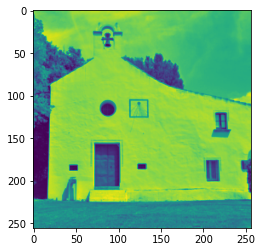

In [ ]:
plt.imshow(d[80][0][0])

In [ ]:
class ConvUP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            #nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1,stride=2),
            nn.MaxPool2d(2),
            #nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class ConvDN(nn.Module):
    def __init__(self, in_channels, mid_channels,last = False):
        super().__init__()
        self.last = last
        self.conv = nn.Sequential(
            #nn.Dropout2d(0.1),
            #nn.ConvTranspose2d(in_channels,in_channels,kernel_size=1,stride=2,padding=0,output_padding = 1),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels,mid_channels, kernel_size=3,padding=1),
            nn.BatchNorm2d(mid_channels)
        )
    def forward(self, x):
        if self.last:
            return torch.sigmoid(self.conv(x))
        else:
            return F.leaky_relu_(self.conv(x))


class AutoEncoder(nn.Module):
    def __init__(self,inputShape):
        super(AutoEncoder, self).__init__()
        self.enlay1 = ConvUP(1,32)
        self.enlay2 = ConvUP(32,64)
        self.enlay3 = ConvUP(64,128)
        self.enlay4 = ConvUP(128,128)
        self.enlay5 = ConvUP(128,128)
        # self.mean = nn.Linear(2048,2048)
        # self.std = nn.Linear(2048,2048)

        # self.ende_inflate = nn.Linear(2048,2048)

        self.delay1 = ConvDN(128,128)
        self.delay2 = ConvDN(128,128)
        self.delay3 = ConvDN(128,64)
        self.delay4 = ConvDN(64,32)
        self.delay5 = ConvDN(32,2,last = True)

    def forward(self, x_img):
        x = x_img
        
        x = self.enlay1(x)
        x = self.enlay2(x)
        x = self.enlay3(x)
        #x = self.enlay4(x)
        #x = self.enlay5(x)

        """
        x = torch.flatten(x,start_dim=1)
        
        m = self.mean(x)
        s = self.std(x)

        std = torch.exp(0.5 * s)
        eps = torch.randn_like(std)

        Z = m + std*eps
        Z = self.ende_inflate(Z)

        x = Z.view(Z.shape[0],8,16,16)
        """
        #x = self.delay1(x)
        #x = self.delay2(x)
        x = self.delay3(x)
        x = self.delay4(x)
        x = self.delay5(x)
        #x = torch.cat([x,x_img],1)
        return x

import torchvision.models as models

sqnet = models.squeezenet1_1(pretrained=True)
sqnetFET = sqnet.features

for p in sqnetFET:
    p.requires_grad = False


def train(model, train_loader, criterion, optimizer, num_epochs, inputShape,device,w,A = None):
    
    #sqnetFET.to("cuda")
    startTime = Tim()
    A_zero = A[0].to(device)
    losses = []
    for e in range(num_epochs):
        
        ssim_graph=[[0],[0]]
        running_loss = 0.0
        i = 0
        for images, out in train_loader:
            images = images.to(device)
            out = out.to(device)

            optimizer.zero_grad()

            # making our predictions
            

            output = model(images)

            # calculating loss

            #loss2 =  torch.mean(2 * torch.log(torch.empty(output.shape).fill_(1)) - torch.log(output-out))
            #loss = -1 * torch.dot(output.flatten(),out.flatten()) 
            #loss = criterion(sqnetFET(out),sqnetFET(output))
            #loss =  - torch.dot(sqnetFET(out).flatten(),sqnetFET(output).flatten())
            #loss = F.mse_loss(sqnetFET(out),sqnetFET(output))
            kld_weight = 1/256 # Account for the minibatch samples from the dataset
            #recons_loss =F.mse_loss(output, out)
            recons_loss = criterion(output,out)
            

            # kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

            # if e < 15:
            #     BETA = 0
            # else:
            #     BETA = e/15 - 1

            loss = recons_loss #+ BETA * kld_weight * kld_loss
            
            
            # backprop step
            loss.backward()

            running_loss += loss.item()
            #losses.append(loss.item())
            if i % 200 == 0:
                losses.append(loss.item())
                # Z = output[0].detach().to("cpu")
                # REF = torch.transpose(out[0].to("cpu"),2,0).numpy()
                # IMG = torch.transpose(Z,2,0).numpy()
                # SSIM = ssim(REF,IMG,multichannel=True,data_range=1.0)
                # ssim_graph[0].append(i)
                # ssim_graph[1].append(SSIM)

                with torch.no_grad():
                    if A != None:
                        OUT = model(A_zero)
                        CAT = torch.cat([A[0].to("cpu"),OUT.to("cpu")],1)
                        
                #         #for k in range(CAT.shape[0]):
                #         CAT_np=FakeLAB2RGB(np.transpose(CAT.numpy()[0],(1,2,0)))
                # w.add_images('f1',torch.cat([OUT[0].unsqueeze(1).to("cpu"),A[1][0].unsqueeze(1).to("cpu")]),i,dataformats = "NCHW")
                # w.add_image('res',torch.Tensor(np.transpose(CAT_np,(2,0,1))),i)
                # w.add_scalar('loss',loss.item(),Tim())

                print("e : %2d ,iter : %4d , loss: %3.10f , t : %3.5f min , SSIM : 5.5f"%(e,i,loss.item(),(Tim() - startTime)/60))
                
                output_r = OUT.to("cpu")
                out_r = A[1][0].to("cpu")
                cmep = 'RdYlBu_r'
                fig,a =  plt.subplots(2,2,sharex=True,sharey=True,)
                a[0,0].imshow(output_r[0][0].detach().numpy(),cmap=cmep)
                a[0,1].imshow(output_r[0][1].detach().numpy(),cmap=cmep)
                a[1,0].imshow(out_r[0].detach().numpy(),cmap=cmep)
                a[1,1].imshow(out_r[1].detach().numpy(),cmap=cmep)
                plt.show()
                                
            i += 1
            optimizer.step()
        #Z = output[0].detach().to("cpu")
        #evaluate(images[0].detach().to('cpu').unsqueeze(0),Z.unsqueeze(0),out[0].to('cpu').unsqueeze(0))
        plt.plot(losses)
        #plt.plot(ssim_graph[0],ssim_graph[1])
        plt.show()

def normlocal(img):
    return img

def test():
    plt.imshow(d[48][1][0])
    plt.show()
    plt.imshow(d[48][1][1])
    plt.show()
    print(d[48][2])
    L = d[48][0].unsqueeze(0)
    A = d[48][1]
    LAB = torch.cat([L,A])
    Z = FakeLAB2RGB(np.transpose(LAB,(1,2,0)).numpy())
    print(Z.min(),Z.max())
    plt.imshow(Z)

def FakeLAB2RGB(img):
    """
    img : numpy with lab format normalized to 0 - 1
    """

    real_lab = (img * [100,255,255]) - [0,127,127]
    return color.lab2xyz(real_lab)

CUDA_LAUNCH_BLOCKING=1
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    path = './val_256'
    batch_size = 16

    dataset = d
    train_loader = DataLoader(dataset,batch_size,shuffle=True,pin_memory=True,num_workers=4)
    
    inputShape = 8
    model = AutoEncoder(inputShape)

    criterion = nn.MSELoss()

    model = model.to(device)
    #optimizer = optim.Adagrad(model.parameters(), lr=1e-3, weight_decay=1e-8)

    #optimizer = optim.SGD(model.parameters(),lr = 1e-2)
    
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    num_epochs = 10
    
    A = next(iter(train_loader))
    
    #model(A[0])

    writer = SummaryWriter()
    train(model, train_loader, criterion, optimizer, num_epochs, inputShape, device,w=writer, A = A)
    writer.close()

    return model,dataset

def test(model,dataset,n):
    A = dataset[n]
    model.to("cpu")
    model.eval()
    
    o = model(A[0].unsqueeze(0))[0] 
    OrignalCAT = torch.cat([A[0].unsqueeze(0),A[1].unsqueeze(0)],1) 
    CATinated = torch.cat([A[0].unsqueeze(0),o.unsqueeze(0)],1)
    evaluate(A[0].unsqueeze(0).detach(),CATinated.detach().numpy(),OrignalCAT.numpy())

def evaluate(X,Z,out):
    """
    X : black and white image (c,h,W)
    Z : output from the model (c,h,w)
    out : orignal image 
    """

    fig,a =  plt.subplots(1,3,sharex=True,sharey=True,figsize=(15, 15*3))
    a[0].imshow(normlocal(X[0])[0],cmap='gray')
    a[1].imshow(normlocal(FakeLAB2RGB(np.transpose(Z[0],(1,2,0)))))
    a[2].imshow(normlocal(FakeLAB2RGB(np.transpose(out[0],(1,2,0)))))
    a[0].axis(False);a[1].axis(False);a[2].axis(False)
    a[0].title.set_text("Input")
    a[1].title.set_text("Output")
    a[2].title.set_text("GroundTruth")
    plt.show()
    REF = np.transpose(out[0],(1,2,0))
    IMG = np.transpose(Z[0],(1,2,0))
    print(ssim(REF,IMG,multichannel=True,data_range=1.0))


e :  0 ,iter :    0 , loss: 0.0409057438 , t : 0.03090 min , SSIM : 5.5f


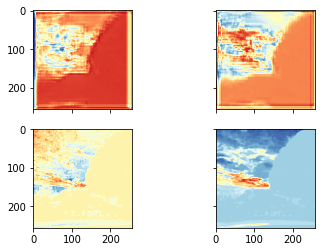

e :  0 ,iter :  200 , loss: 0.0018966163 , t : 0.85996 min , SSIM : 5.5f


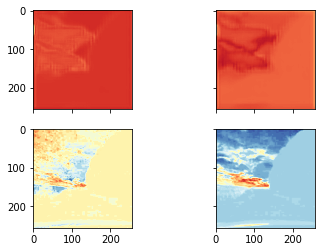

e :  0 ,iter :  400 , loss: 0.0028373171 , t : 1.96389 min , SSIM : 5.5f


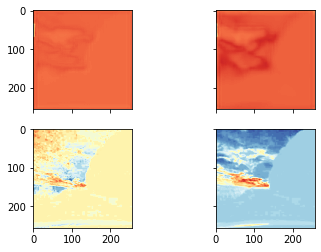

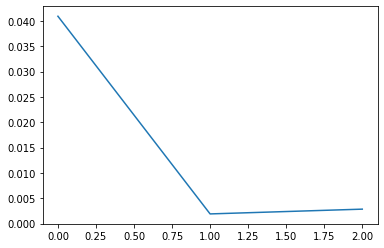

e :  1 ,iter :    0 , loss: 0.0025328947 , t : 2.61910 min , SSIM : 5.5f


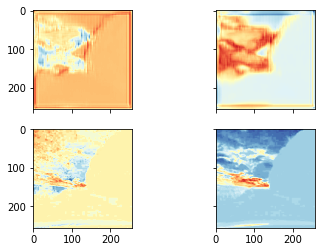

e :  1 ,iter :  200 , loss: 0.0038187124 , t : 3.23881 min , SSIM : 5.5f


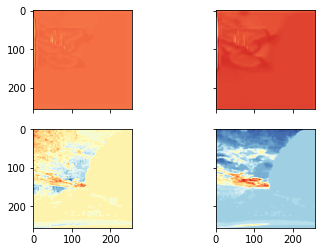

e :  1 ,iter :  400 , loss: 0.0042853425 , t : 4.19877 min , SSIM : 5.5f


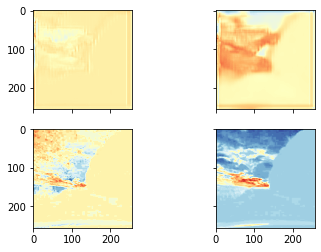

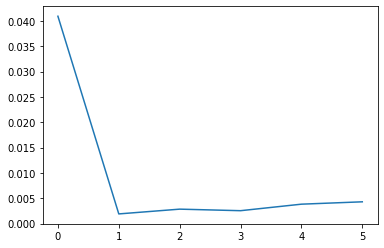

e :  2 ,iter :    0 , loss: 0.0025561210 , t : 4.83555 min , SSIM : 5.5f


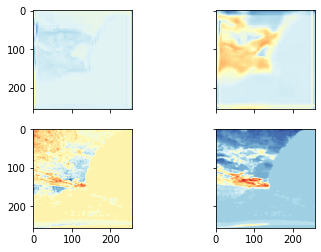

e :  2 ,iter :  200 , loss: 0.0026154346 , t : 5.22825 min , SSIM : 5.5f


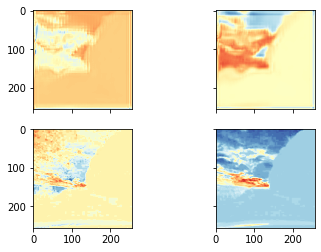

e :  2 ,iter :  400 , loss: 0.0032581417 , t : 5.96460 min , SSIM : 5.5f


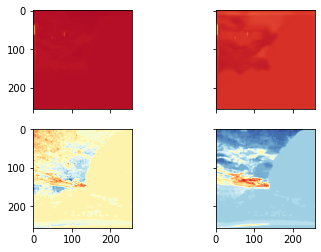

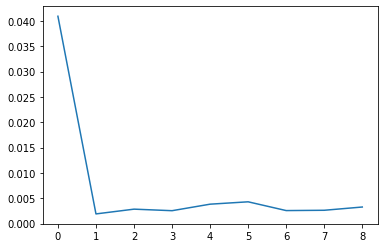

e :  3 ,iter :    0 , loss: 0.0028266769 , t : 6.58508 min , SSIM : 5.5f


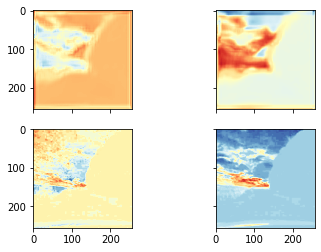

e :  3 ,iter :  200 , loss: 0.0020560985 , t : 6.96523 min , SSIM : 5.5f


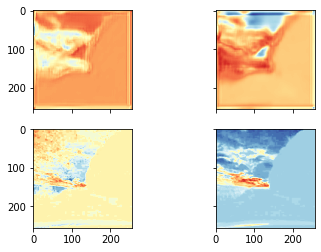

e :  3 ,iter :  400 , loss: 0.0018017045 , t : 7.71548 min , SSIM : 5.5f


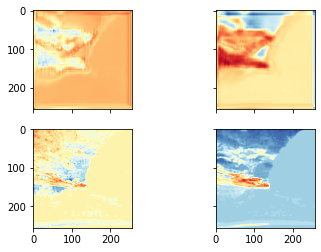

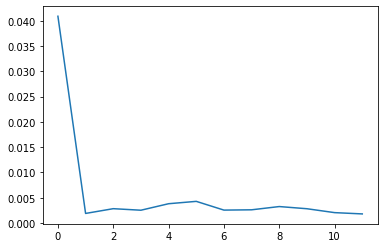

e :  4 ,iter :    0 , loss: 0.0016484829 , t : 8.32653 min , SSIM : 5.5f


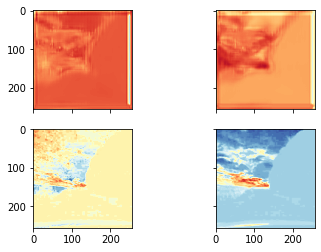

e :  4 ,iter :  200 , loss: 0.0038173080 , t : 8.72638 min , SSIM : 5.5f


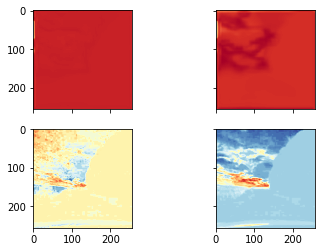

e :  4 ,iter :  400 , loss: 0.0023636338 , t : 9.51441 min , SSIM : 5.5f


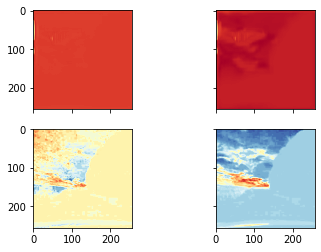

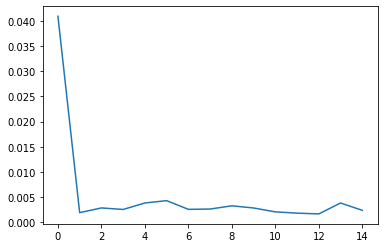

e :  5 ,iter :    0 , loss: 0.0026363311 , t : 10.14278 min , SSIM : 5.5f


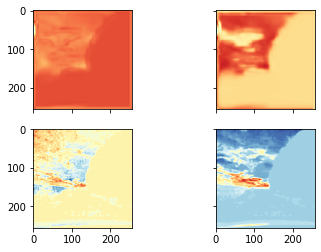

e :  5 ,iter :  200 , loss: 0.0022547827 , t : 10.56260 min , SSIM : 5.5f


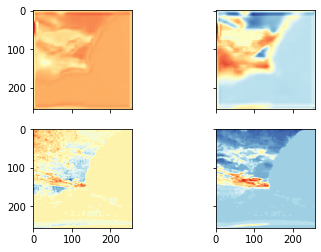

e :  5 ,iter :  400 , loss: 0.0017009836 , t : 11.35611 min , SSIM : 5.5f


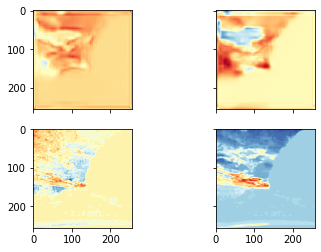

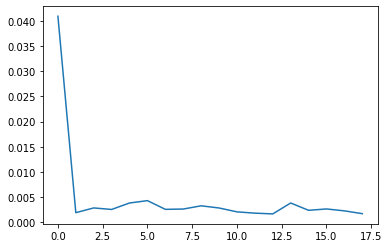

e :  6 ,iter :    0 , loss: 0.0019940091 , t : 11.99232 min , SSIM : 5.5f


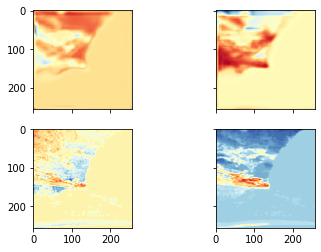

e :  6 ,iter :  200 , loss: 0.0016582106 , t : 12.43704 min , SSIM : 5.5f


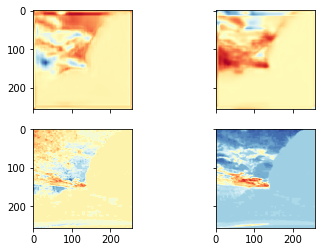

e :  6 ,iter :  400 , loss: 0.0012612583 , t : 13.30813 min , SSIM : 5.5f


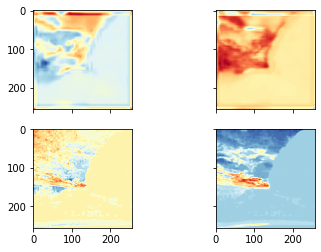

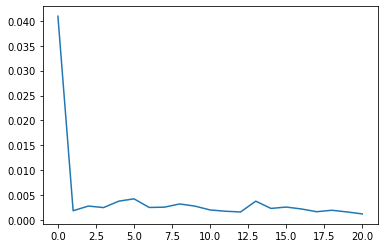

e :  7 ,iter :    0 , loss: 0.0030622378 , t : 13.94282 min , SSIM : 5.5f


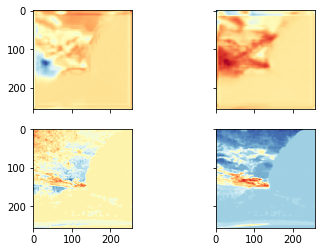

e :  7 ,iter :  200 , loss: 0.0017246088 , t : 14.40075 min , SSIM : 5.5f


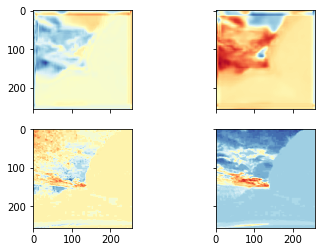

e :  7 ,iter :  400 , loss: 0.0030448996 , t : 15.26602 min , SSIM : 5.5f


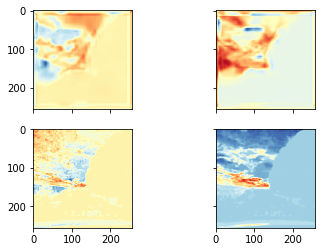

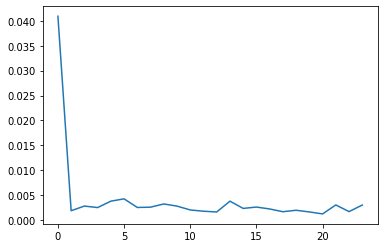

e :  8 ,iter :    0 , loss: 0.0027269032 , t : 15.91663 min , SSIM : 5.5f


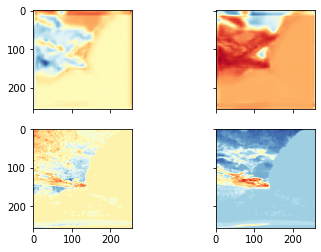

e :  8 ,iter :  200 , loss: 0.0025467053 , t : 16.37771 min , SSIM : 5.5f


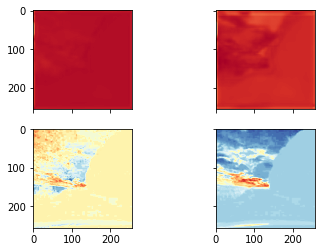

e :  8 ,iter :  400 , loss: 0.0023109168 , t : 17.23531 min , SSIM : 5.5f


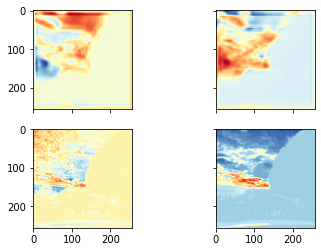

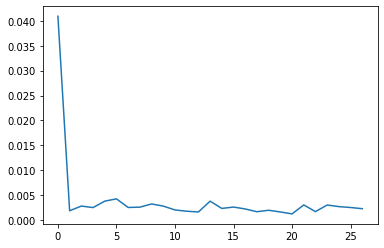

e :  9 ,iter :    0 , loss: 0.0021209803 , t : 17.87754 min , SSIM : 5.5f


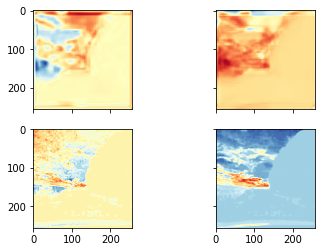

e :  9 ,iter :  200 , loss: 0.0021973590 , t : 18.33582 min , SSIM : 5.5f


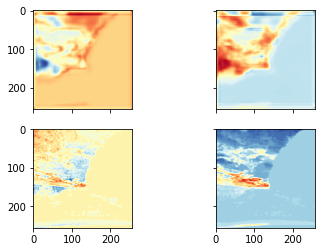

e :  9 ,iter :  400 , loss: 0.0021678871 , t : 19.21026 min , SSIM : 5.5f


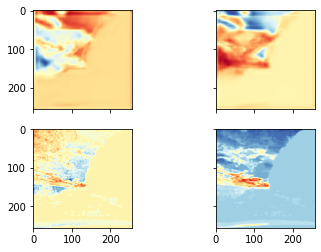

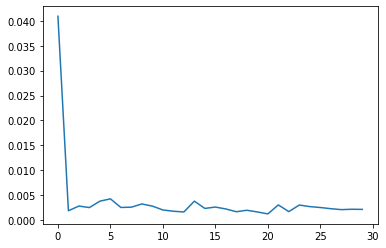

In [ ]:
m,d = main()

In [ ]:
#%load_ext tensorboard
%tensorboard --logdir runs/

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


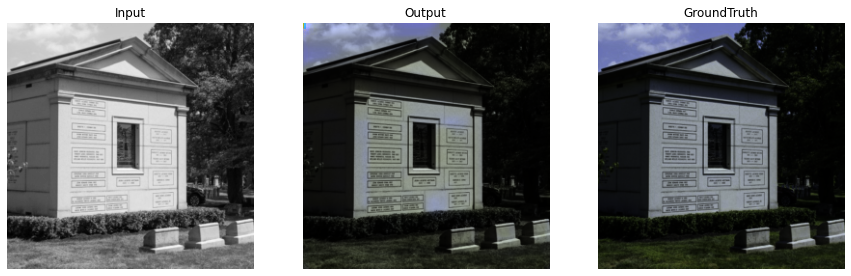

0.9352491246635318


In [ ]:
#@title Default title text { run: "auto" }
idx = 6869 #@param {type:"slider", min:0, max:8200, step:1}
test(m,d,idx)   

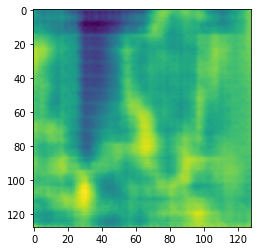

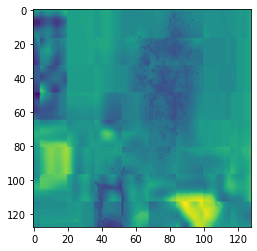

In [ ]:

 A = d[33]
m.to("cpu")
m.eval()
o = m(A[0].unsqueeze(0))[0]
plt.imshow(o[0][1].detach().numpy())
plt.show()
plt.imshow(A[1][1])

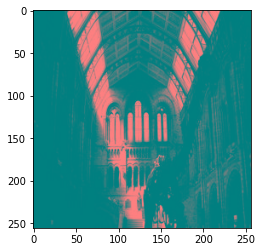

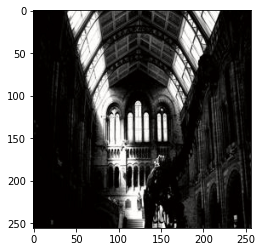

In [ ]:
from skimage import io, color
rgb = io.imread("./val_256/Places365_val_00014486.jpg")
lab = (((color.rgb2lab(rgb)+[0,128,128]) / [100, 255, 255])*255).astype(np.uint8)
lab_scaled = (lab)
plt.imshow(lab_scaled)
plt.show()
real_lab = (lab_scaled/255 * [100,255,255]) - [0,127,127]
plt.imshow(color.lab2rgb(real_lab))

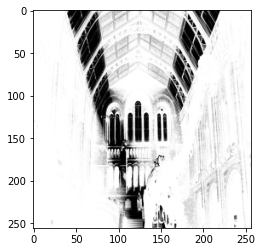

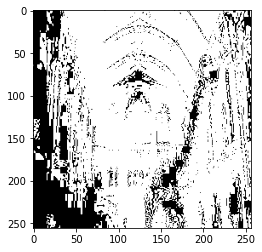

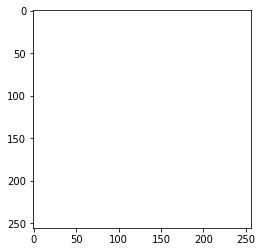

In [ ]:
plt.imshow(lab[:,:,0],cmap="Greys",)
plt.show()
plt.imshow((lab[:,:,1]),cmap="Greys")
plt.show()
plt.imshow((lab[:,:,2]),cmap="Greys")
plt.show()


In [ ]:
import torch.onnx
from torch import nn

# import config

# device = "cuda"
# dataset = REcolorDataset(target = [0])
# model = AutoEncoder
# model = nn.DataParallel(model)
# model.load_state_dict(torch.load(config.MODEL_PATH))
# model.eval()

# print(model)

# x_img = dataset[0]["x_img"]

# torch.onnx.export(
#     model, (x_img), "model.onnx",
#     input_names = ["x_img"],
#     output_names = ["output"],
#     dynamic_axes = {
#         "x_img": {0: "bs"},
#         "output": {0: "bs"}
#     }
# )
bs = 8
x = torch.randn(1, 1, 256, 256, requires_grad=True)
torch_out = AutoEncoder(69)(x)

# Export the model
torch.onnx.export(AutoEncoder(69),                                # model being run
                  x,                                            # model input (or a tuple for multiple inputs)
                  "model1.onnx",                                 # where to save the model (can be a file or file-like object)
                  export_params=True,                           # store the trained parameter weights inside the model file
                  opset_version=7,                             # the ONNX version to export the model to
                  verbose = 1,
                  do_constant_folding=True,                     # whether to execute constant folding for optimization
                  input_names = ['x_img'],                      # the model's input names
                  output_names = ['output'],                    # the model's output names
                  #dynamic_axes={'x_img' : {0 : 'bs'},   # variable lenght axes
                    #             'output' : {0 : 'bs'}}
                  )

graph(%x_img : Float(1:65536, 1:65536, 256:256, 256:1),
      %enlay1.conv.0.weight : Float(32:9, 1:9, 3:3, 3:1),
      %enlay1.conv.0.bias : Float(32:1),
      %enlay1.conv.1.weight : Float(32:288, 32:9, 3:3, 3:1),
      %enlay1.conv.1.bias : Float(32:1),
      %enlay2.conv.0.weight : Float(64:288, 32:9, 3:3, 3:1),
      %enlay2.conv.0.bias : Float(64:1),
      %enlay2.conv.1.weight : Float(64:576, 64:9, 3:3, 3:1),
      %enlay2.conv.1.bias : Float(64:1),
      %enlay3.conv.0.weight : Float(128:576, 64:9, 3:3, 3:1),
      %enlay3.conv.0.bias : Float(128:1),
      %enlay3.conv.1.weight : Float(128:1152, 128:9, 3:3, 3:1),
      %enlay3.conv.1.bias : Float(128:1),
      %enlay4.conv.0.weight : Float(128:1152, 128:9, 3:3, 3:1),
      %enlay4.conv.0.bias : Float(128:1),
      %enlay4.conv.1.weight : Float(128:1152, 128:9, 3:3, 3:1),
      %enlay4.conv.1.bias : Float(128:1),
      %enlay5.conv.0.weight : Float(128:1152, 128:9, 3:3, 3:1),
      %enlay5.conv.0.bias : Float(128:1),
      %enla

/usr/local/lib/python3.6/dist-packages/torch/onnx/symbolic_helper.py:253: UserWarning: You are trying to export the model with onnx:Upsample for ONNX opset version 7. This operator might cause results to not match the expected results by PyTorch.
ONNX's Upsample/Resize operator did not match Pytorch's Interpolation until opset 11. Attributes to determine how to transform the input were added in onnx:Resize in opset 11 to support Pytorch's behavior (like coordinate_transformation_mode and nearest_mode).
We recommend using opset 11 and above for models using this operator. 
  "" + str(_export_onnx_opset_version) + ". "
/usr/local/lib/python3.6/dist-packages/torch/onnx/symbolic_helper.py:176: UserWarning: ONNX export failed on upsample_nearest2d because torch._C.Value (output_size) indexing not supported
  warnings.warn("ONNX export failed on " + op + " because " + msg + " not supported")


RuntimeError: ignored

In [ ]:
!pip install config

In [ ]:
!pip install onnx

In [ ]:
traced_foo = torch.jit.trace(AutoEncoder(69), torch.randn(1, 1, 256, 256, requires_grad=True))